In [421]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time

import warnings
warnings.filterwarnings('ignore')

# Functions

In [41]:
# Augmented Dickey-Fuller Test - Checking Stationarity
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [2]:
data = pd.read_csv('C:/Users/migue/Desktop/data_preprocess.csv')

In [3]:
data.head()

,Unnamed: 0,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Value,Day of the Week,Quarter,Units
0,1,16,11,306,649,1970,1,2017-03-04,1540.0,5,1,2.0
1,3,16,11,306,649,1970,1,2016-05-02,3080.0,0,2,4.0
2,5,16,11,306,649,1970,1,2016-10-24,1540.0,0,4,2.0
3,9,16,11,306,649,1970,1,2017-10-13,1620.0,4,4,2.0
4,10,16,11,306,649,1970,1,2017-10-14,1620.0,5,4,2.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91171152 entries, 0 to 91171151
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   ProductFamily_ID    int64  
 2   ProductCategory_ID  int64  
 3   ProductBrand_ID     int64  
 4   ProductName_ID      int64  
 5   ProductPackSKU_ID   int64  
 6   Point-of-Sale_ID    int64  
 7   Date                object 
 8   Value               float64
 9   Day of the Week     int64  
 10  Quarter             int64  
 11  Units               float64
dtypes: float64(2), int64(9), object(1)
memory usage: 8.2+ GB


In [6]:
df=data.loc[:,['Date','Point-of-Sale_ID','Value','Units']].copy()

In [7]:
df.head(3)

,Date,Point-of-Sale_ID,Value,Units
0,2017-03-04,1,1540.0,2.0
1,2016-05-02,1,3080.0,4.0
2,2016-10-24,1,1540.0,2.0


In [9]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [10]:
df['week'] = df['Date'] - pd.to_timedelta(7, unit='d')

In [12]:
df.sort_values(by='Date')

,Date,Point-of-Sale_ID,Value,Units,week
87772675,2016-01-01,394,505.0,1.0,2015-12-25
8441810,2016-01-01,34,690.0,1.0,2015-12-25
7390803,2016-01-01,30,668.0,1.0,2015-12-25
56662473,2016-01-01,257,3346.0,2.0,2015-12-25
37942422,2016-01-01,161,482.0,1.0,2015-12-25
...,...,...,...,...,...
7549823,2019-11-01,30,2530.0,1.0,2019-10-25
8427687,2019-11-01,34,4558.0,1.0,2019-10-25
47970927,2019-11-01,212,997.0,1.0,2019-10-25
11387624,2019-11-01,46,891.0,1.0,2019-10-25


In [18]:
vdf = df.groupby(['Point-of-Sale_ID', pd.Grouper(key='week', freq='W-MON')])['Value'].sum().reset_index().sort_values('week')

In [373]:
vdf[vdf['Point-of-Sale_ID']==1]

,Point-of-Sale_ID,week,Value
0,1,2015-12-28,1.319957e+06
1,1,2016-01-04,5.184376e+06
2,1,2016-01-11,4.643021e+06
3,1,2016-01-18,4.213833e+06
4,1,2016-01-25,4.508332e+06
...,...,...,...
196,1,2019-09-30,4.967867e+06
197,1,2019-10-07,5.721211e+06
198,1,2019-10-14,5.120284e+06
199,1,2019-10-21,5.358139e+06


In [19]:
vdf.head(3)

,Point-of-Sale_ID,week,Value
0,1,2015-12-28,1319957.0
55043,275,2015-12-28,1182271.0
54842,274,2015-12-28,972546.0


In [20]:
grouped=vdf.groupby('week')['Value'].sum()

In [27]:
grouped

week
2015-12-28    4.841609e+08
2016-01-04    1.599968e+09
2016-01-11    1.536479e+09
2016-01-18    1.468741e+09
2016-01-25    1.452084e+09
                  ...     
2019-09-30    1.768136e+09
2019-10-07    2.018785e+09
2019-10-14    1.845840e+09
2019-10-21    1.782655e+09
2019-10-28    9.929285e+08
Name: Value, Length: 201, dtype: float64

In [25]:
weekly=grouped[1:-1] # removing the first and last date for lack of values 

In [26]:
weekly

week
2016-01-04    1.599968e+09
2016-01-11    1.536479e+09
2016-01-18    1.468741e+09
2016-01-25    1.452084e+09
2016-02-01    1.438068e+09
                  ...     
2019-09-23    1.753093e+09
2019-09-30    1.768136e+09
2019-10-07    2.018785e+09
2019-10-14    1.845840e+09
2019-10-21    1.782655e+09
Name: Value, Length: 199, dtype: float64

In [28]:
fig = px.line(x=weekly.index, y=weekly, labels={'x':'Date', 'y':'Value'})
fig.show()

# Forecasting

In [30]:
#infer the frequency of the data
forecast = weekly.asfreq(pd.infer_freq(weekly.index))

In [36]:
start_date = datetime(2016,1,1)
end_date = datetime(2019,11,1)
lim_df = forecast[start_date:end_date]
lim_df.head(3)

week
2016-01-04    1.599968e+09
2016-01-11    1.536479e+09
2016-01-18    1.468741e+09
Freq: W-MON, Name: Value, dtype: float64

## Is there a trend?
We will check startionarity by performing a Augmented Dickey-Fuller Test

In [44]:
perform_adf_test(lim_df)

ADF Statistic: -1.038056
p-value: 0.739133


#### p-value of 0.73 
We will have to remove the trend. Basically taking each data point and subtract the datapoint from the month that comes prior.

In [45]:
first_diff = lim_df.diff()[1:]

In [46]:
first_diff.head(3)

week
2016-01-11   -6.348937e+07
2016-01-18   -6.773779e+07
2016-01-25   -1.665714e+07
Freq: W-MON, Name: Value, dtype: float64

In [47]:
fig = px.line(x=first_diff.index, y=first_diff, labels={'x':'Date', 'y':'Value'})
fig.show()

Straightaway we can see that now the time series is distributed around 0. Now let's perform the ADF test to see.

In [48]:
perform_adf_test(first_diff)

ADF Statistic: -9.053647
p-value: 0.000000


#### p-value of 0!!!
We can now move on with the model.

### ACF

In [57]:
acf_vals = acf(first_diff)
fig = px.bar(y=acf_vals)
fig.show()

There seems to exist some repetition in 4 to 4 marks (Maybe Monthly???), however those may not be enough to warrant seasonality.

##### Maybe a seasonal MA of 1 month?

### PACF

In [60]:
pacf_vals = pacf(first_diff)
fig = px.bar(y=pacf_vals)
fig.show()

There seems to exist some repetition in 3 to 4 lags (Maybe Monthly???), however those may not be enough to warrant seasonality.

##### Maybe a seasonal AR of 1 month?

## Setting up Train and Test Data

In [347]:
train_end = datetime(2019,8,30)
test_end = datetime(2019,11,1)

train_data = lim_df[:train_end]
test_data = lim_df[train_end + timedelta(days=1):test_end]

In [348]:
train_data.tail(3)

week
2019-08-12    1.525958e+09
2019-08-19    1.611158e+09
2019-08-26    1.587438e+09
Freq: W-MON, Name: Value, dtype: float64

In [349]:
test_data.head(3)

week
2019-09-02    1.703456e+09
2019-09-09    1.787697e+09
2019-09-16    1.742751e+09
Freq: W-MON, Name: Value, dtype: float64

# Fit the SARIMA Model

In [350]:
my_order = (1,1,1) #(p,d,q) (AR,I,MA)
my_seasonal_order = (1, 0, 1, 52) #
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [351]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

C:\Users\migue\.conda\envs\BCDS\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\migue\.conda\envs\BCDS\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Model Fitting Time: 2.740751028060913


In [352]:
#summary of the model
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Value   No. Observations:                  191
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 52)   Log Likelihood               -3804.768
Date:                            Tue, 18 May 2021   AIC                           7619.535
Time:                                    17:09:03   BIC                           7635.771
Sample:                                01-04-2016   HQIC                          7626.112
                                     - 08-26-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1312      0.044      2.951      0.003       0.044       0.218
ma.L1         -0.8052      0.045   

In [353]:
#get the predictions and residuals
predictions = model_fit.forecast(steps=len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

In [354]:
predictions

week
2019-09-02    1.718394e+09
2019-09-09    1.729712e+09
2019-09-16    1.740146e+09
2019-09-23    1.742700e+09
2019-09-30    1.709200e+09
2019-10-07    1.820744e+09
2019-10-14    1.760693e+09
2019-10-21    1.740074e+09
Freq: W-MON, Name: predicted_mean, dtype: float64

In [355]:
residuals

week
2019-09-02   -1.493837e+07
2019-09-09    5.798482e+07
2019-09-16    2.604542e+06
2019-09-23    1.039314e+07
2019-09-30    5.893600e+07
2019-10-07    1.980408e+08
2019-10-14    8.514676e+07
2019-10-21    4.258023e+07
Freq: W-MON, dtype: float64

In [357]:
fig = px.line(x=residuals.index, y=residuals, labels={'x':'Date', 'y':'Error'})
fig.show()

In [358]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=lim_df.index, y=lim_df,
                    mode='lines',
                    name='TimeSeries'))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions,
                    mode='lines',
                    name='Predictions'))

fig.show()

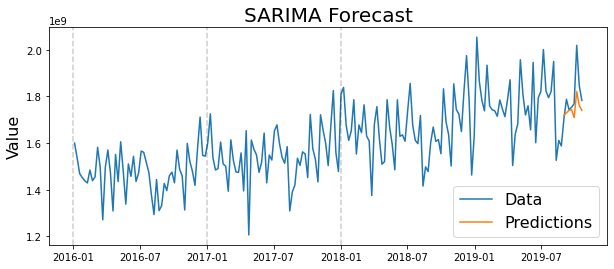

In [370]:
plt.figure(figsize=(10,4))

plt.plot(lim_df)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('SARIMA Forecast', fontsize=20)
plt.ylabel('Value', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [360]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0313


In [361]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 83259281.56879443


#### CONCLUSION FROM THE FIRST FORECAST
After testing the models for sucessive iterations we tried to better understand the relation, troughout time the and as we go further into the forecast the errors normally tend to increase.

TO NOTE: The first 5 forecasts are really good and from there normally the forecasts tended to get worse

By using seasonal 1 year lag on forecast we managed to get the significantly better results than with monthly lags.

# Rolling Forecast Origin

In [362]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_df[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

C:\Users\migue\.conda\envs\BCDS\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\migue\.conda\envs\BCDS\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



In [363]:
rolling_residuals = test_data - rolling_predictions

In [364]:
rolling_residuals

week
2019-09-02   -1.493837e+07
2019-09-09    6.300519e+07
2019-09-16   -1.466148e+07
2019-09-23    3.350913e+06
2019-09-30    5.027491e+07
2019-10-07    1.728783e+08
2019-10-14    8.637790e+06
2019-10-21   -2.001508e+07
Freq: W-MON, Name: Value, dtype: float64

In [371]:
fig = px.line(x=rolling_residuals.index, y=rolling_residuals, labels={'x':'Date', 'y':'Error'})
fig.show()

Text(0, 0.5, 'Error')

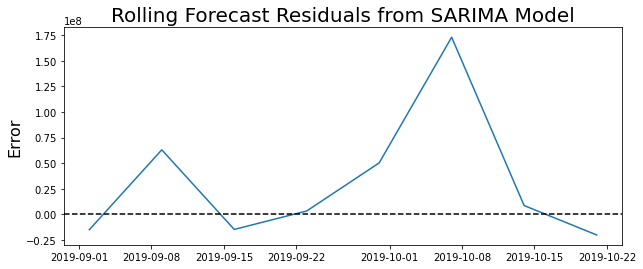

In [365]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [372]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=lim_df.index, y=lim_df,
                    mode='lines',
                    name='TimeSeries'))
fig.add_trace(go.Scatter(x=rolling_predictions.index, y=rolling_predictions,
                    mode='lines',
                    name='Predictions'))

fig.show()

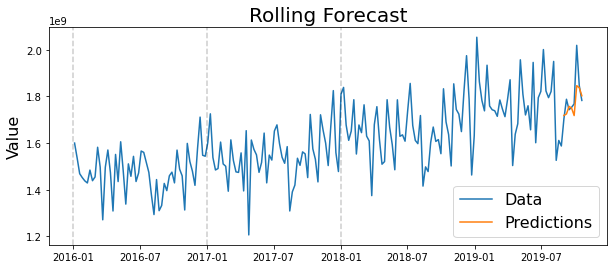

In [366]:
plt.figure(figsize=(10,4))

plt.plot(lim_df)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Rolling Forecast', fontsize=20)
plt.ylabel('Value', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [367]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.023


In [368]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 68290456.18511638


# FUNCTION

In [381]:
def forecast_by_POS(POS_ID):
    # Setting up the group by on the Point-of-Sale_ID
    grouped=vdf[vdf['Point-of-Sale_ID']==POS_ID].groupby('week')['Value'].sum()
    # removing the first and last date for lack of values 
    weekly=grouped[1:-1]
    
    #-----------// FORECASTING //-----------#
    # Infer the frequency of the data
    forecast = weekly.asfreq(pd.infer_freq(weekly.index))
    # Set DF
    start_date = datetime(2016,1,1)
    end_date = datetime(2019,11,1)
    lim_df = forecast[start_date:end_date]
    # Get First Diferences to eliminate Trend
    first_diff = lim_df.diff()[1:]
    
    # Set Train and Test Values
    train_end = datetime(2019,8,30)
    test_end = datetime(2019,11,1)
    train_data = lim_df[:train_end]
    test_data = lim_df[train_end + timedelta(days=1):test_end]
    
    # SARIMA
    my_order = (1,1,1) #(p,d,q) (AR,I,MA)
    my_seasonal_order = (1, 0, 1, 52)
    # Define model
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()
    # Get the predictions and residuals
    predictions = model_fit.forecast(steps=len(test_data))
    predictions = pd.Series(predictions, index=test_data.index)
    residuals = test_data - predictions
    
    return predictions,residuals

In [422]:
_42 = forecast_by_POS(42)

In [414]:
def graph_pred(POS_ID):
    # running prediction
    predictions = forecast_by_POS(42)[0]
    
    # Data
    # Setting up the group by on the Point-of-Sale_ID
    grouped=vdf[vdf['Point-of-Sale_ID']==POS_ID].groupby('week')['Value'].sum()
    # removing the first and last date for lack of values 
    weekly=grouped[1:-1]
    
    # Infer the frequency of the data
    forecast = weekly.asfreq(pd.infer_freq(weekly.index))
    # Set DF
    start_date = datetime(2016,1,1)
    end_date = datetime(2019,11,1)
    lim_df = forecast[start_date:end_date]
    # Get First Diferences to eliminate Trend
    first_diff = lim_df.diff()[1:]
    
    # Set Train and Test Values
    train_end = datetime(2019,8,30)
    test_end = datetime(2019,11,1)
    train_data = lim_df[:train_end]
    test_data = lim_df[train_end + timedelta(days=1):test_end]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=lim_df.index, y=lim_df,
                        mode='lines',
                        name='TimeSeries'))
    fig.add_trace(go.Scatter(x=predictions.index, y=predictions,
                        mode='lines',
                        name='Predictions'))

    return fig.show()

In [419]:
def graph_residuals(POS_ID):
    # Setting up the group by on the Point-of-Sale_ID
    grouped=vdf[vdf['Point-of-Sale_ID']==POS_ID].groupby('week')['Value'].sum()
    # removing the first and last date for lack of values 
    weekly=grouped[1:-1]
    
    #-----------// FORECASTING //-----------#
    # Infer the frequency of the data
    forecast = weekly.asfreq(pd.infer_freq(weekly.index))
    # Set DF
    start_date = datetime(2016,1,1)
    end_date = datetime(2019,11,1)
    lim_df = forecast[start_date:end_date]
    # Get First Diferences to eliminate Trend
    first_diff = lim_df.diff()[1:]
    
    # Set Train and Test Values
    train_end = datetime(2019,8,30)
    test_end = datetime(2019,11,1)
    train_data = lim_df[:train_end]
    test_data = lim_df[train_end + timedelta(days=1):test_end]
    
    # SARIMA
    my_order = (1,1,1) #(p,d,q) (AR,I,MA)
    my_seasonal_order = (1, 0, 1, 52)
    # Define model
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()
    # Get the predictions and residuals
    predictions = model_fit.forecast(steps=len(test_data))
    predictions = pd.Series(predictions, index=test_data.index)
    residuals = test_data - predictions
    
    fig = px.line(x=residuals.index, y=residuals, labels={'x':'Date', 'y':'Error'})

    return fig.show()

In [423]:
graph_pred(POS_ID=42)

In [424]:
graph_residuals(POS_ID=42)

In [431]:
def indicators(POS_ID):
    # Setting up the group by on the Point-of-Sale_ID
    grouped=vdf[vdf['Point-of-Sale_ID']==POS_ID].groupby('week')['Value'].sum()
    # removing the first and last date for lack of values 
    weekly=grouped[1:-1]
    
    #-----------// FORECASTING //-----------#
    # Infer the frequency of the data
    forecast = weekly.asfreq(pd.infer_freq(weekly.index))
    # Set DF
    start_date = datetime(2016,1,1)
    end_date = datetime(2019,11,1)
    lim_df = forecast[start_date:end_date]
    # Get First Diferences to eliminate Trend
    first_diff = lim_df.diff()[1:]
    
    # Set Train and Test Values
    train_end = datetime(2019,8,30)
    test_end = datetime(2019,11,1)
    train_data = lim_df[:train_end]
    test_data = lim_df[train_end + timedelta(days=1):test_end]
    
    # SARIMA
    my_order = (1,1,1) #(p,d,q) (AR,I,MA)
    my_seasonal_order = (1, 0, 1, 52)
    # Define model
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()
    # Get the predictions and residuals
    predictions = model_fit.forecast(steps=len(test_data))
    predictions = pd.Series(predictions, index=test_data.index)
    residuals = test_data - predictions
    
    MAPE = round(np.mean(abs(residuals/test_data)),4)
    RMSE = np.sqrt(np.mean(residuals**2))

    return MAPE,RMSE

In [432]:
indicators(POS_ID=42)

(0.0368, 405992.1318170488)